# Import packages

In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import *

# Load Shapes

In [2]:
posns = np.load("./data/dithPos.dat",allow_pickle=True)
n_points = 50
heights = [np.ones(n_points) / n_points for i in range(len(posns))]

Examples for paper.

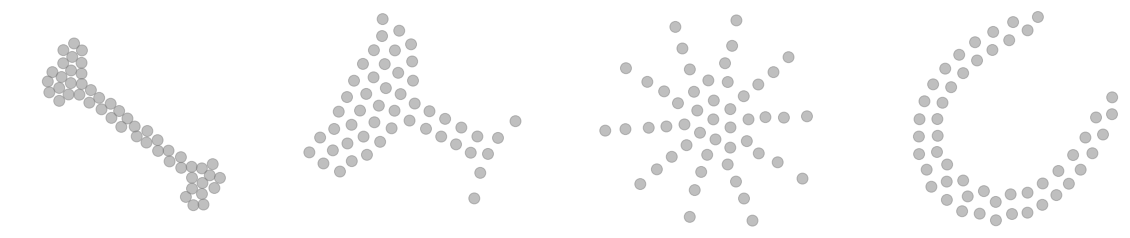

In [3]:
ex_posns = [posns[4], posns[35], posns[45], posns[60]]
ex_heights = [heights[4], heights[35], heights[45], heights[60]]
scatter_atomic(ex_posns, ex_heights, n_plots_per_col=4, xmarkers=False, axis_off=True, margin_fac=0.05)

In [4]:
numItem = 20
classes = np.arange(4)
N = len(classes)*20

# GW distances

In [5]:
N = 80
Ms = []
for i in range(80):
    M = ot.dist(posns[i], posns[i], metric="euclidean")
    posns[i] /= np.max(M)
    Ms.append(M/np.max(M))

In [6]:
st = time.time()        
gw = np.zeros((N,N))
for i in range(N):
    M1 = Ms[i]
    height1 = heights[i]
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j]
        gw[i, j] = ot.gromov.gromov_wasserstein2(M1, M2, height1, height2, 'square_loss')
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")

GW computation: 9.21s


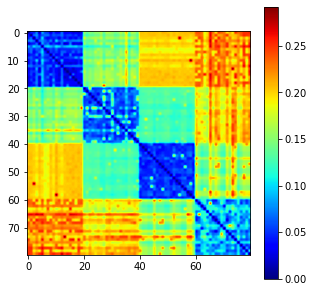

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(gw, cmap='jet')
plt.colorbar()
plt.show()

# Reference

In [8]:
idx_bary = [c*numItem for c in range(len(classes))] #indices of shapes for barycenter computation
n_bary = len(idx_bary)
k_bary = 35
    
st = time.time()   
height_ref = ot.unif(k_bary)
M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                           ps = np.array(heights)[idx_bary], p = height_ref, lambdas = ot.unif(n_bary), loss_fun='square_loss',
                                           max_iter=400, tol=1e-12,random_state=2746,log=False)
et = time.time()

print("Barycenter computation: " + str(np.round(et-st,2)) + "s")

Barycenter computation: 1.29s


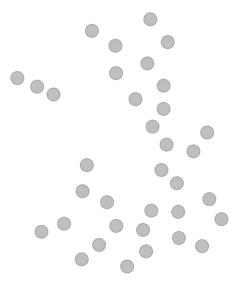

In [9]:
#embedding and plot
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(M_ref)

scatter_atomic(embedding, height_ref, n_plots_per_col=1, xmarkers=False, axis_off=True, margin_fac=0.05)

# LGW distances

In [10]:
lgw,t = lgw_procedure(M_ref,height_ref,posns,Ms,heights,mode="euclidean")
print("LGW computation: " + str(np.round(t,2)) + "s")

LGW computation: 0.51s


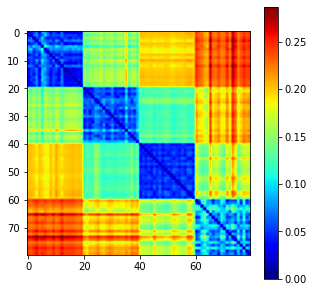

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(lgw, cmap='jet')
plt.colorbar()
plt.show()

In [12]:
print("PCC: " + str(np.round(np.corrcoef(gw.flatten(),lgw.flatten())[1,0],4)))

m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
m_lgw = np.ma.masked_equal(lgw, 0.0, copy=False)

print("MRE: " + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)))

PCC: 0.9612
MRE: 0.0854


# Scale images for paper

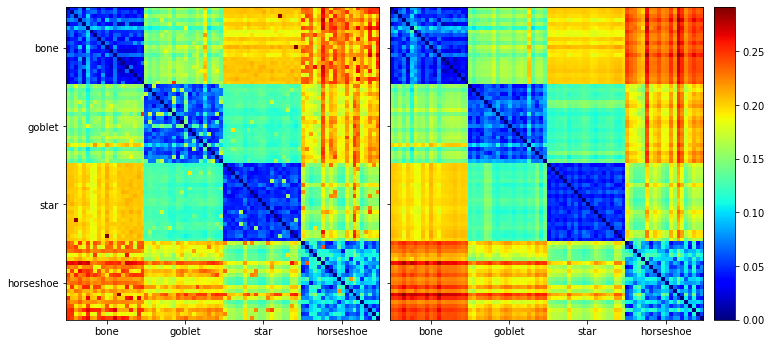

In [13]:
data1 = gw
data2 = lgw

resultant = [data1,data2]

min_val, max_val = np.amin(resultant), np.amax(resultant)


# Set up figure and image grid
fig = plt.figure(figsize=(12, 6))


grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

animal_strings = ["bone","goblet","star","horseshoe"]
x = [10,30,50,70]

plt.setp(grid, xticks=x, xticklabels=animal_strings,
        yticks=x, yticklabels=animal_strings)

# Add data to image grid
i=0
for ax in grid:
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    if i == 0:
        im = ax.imshow(data1, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(data2, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
#matplotlib.colorbar.Colorbar(ax.cax,im)
#ax.cax.cla()
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

# Classification

In [14]:
X = np.arange(N)                                           #dataset
y = np.concatenate([np.ones(numItem)*i for i in classes])  #labels

# Confusion matrix

In [15]:
def conf_mat(dists,X,y,n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

In [16]:
#compute confusion matrices
conf_gw = conf_mat(gw,X=X,y=y) 
conf_lgw = conf_mat(lgw,X=X,y=y)

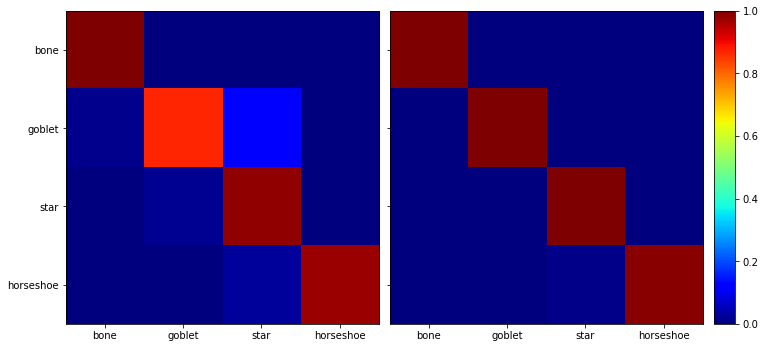

In [17]:
data1 = conf_gw/np.max(conf_gw)
data2 = conf_lgw/np.max(conf_lgw)

#resultant = [data1,data2]

min_val, max_val = 0,1


# Set up figure and image grid
fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111,          
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
animal_strings = ["bone","goblet","star","horseshoe"]
x = [0,1,2,3]
plt.setp(grid, xticks=x, xticklabels=animal_strings,
        yticks=x, yticklabels=animal_strings)

# Add data to image grid
i=0
for ax in grid:
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    if i == 0:
        im = ax.imshow(data1, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(data2, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.show()

# Perform 10-fold cross validation

In [18]:
gamma = 10

In [19]:
#K_folds for GW
k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
k_folds.get_n_splits(X,y)

accs_gw = []

for train_index,test_index in k_folds.split(X,y):
    #get train and test data for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #set up SVM
    kernel_train = np.exp(-gamma*gw[X_train].T[X_train].T)
    svc = svm.SVC(kernel="precomputed")
    
    #fit SVM
    clf = svc.fit(kernel_train, y_train)

    kernel_test = np.exp(-gamma*gw[X_test].T[X_train].T)
    #kernel_test = np.array([[gw_kernel(i,j,gamma=gamma) for i in X_train] for j in X_test])
    acc = clf.score(kernel_test, y_test)
    accs_gw.append(acc)

In [20]:
print("Accuracies: " + str(accs_gw) + ",\nMean accuracy: " + str(np.mean(accs_gw)))

Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
Mean accuracy: 1.0


In [22]:
def k_folds_lgw(k_bary):
    #K_folds for LGW
    np.random.seed(0)

    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)
    accs_lgw = []
    corcoeffs = []
    mres = []

    count = 0
    for train_index,test_index in k_folds.split(X,y):
        #get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #compute barycenter for train
        idx_bary = [np.random.choice(np.where(y_train == i)[0]) for i in classes]
        count += 1
        n_bary = len(idx_bary)
        #k_bary = 15

        st = time.time()
        M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                                   ps = np.array(heights)[idx_bary], p = ot.unif(k_bary), lambdas = ot.unif(n_bary), loss_fun='square_loss',  # 5e-4,
                                                   max_iter=200, tol=1e-12,random_state=2746)
        et = time.time()
        height_ref = ot.unif(k_bary)
        #print("Computing the barycenter took " + str(et-st) + " seconds.")

        #compute LGW
        lgw,t = lgw_procedure(M_ref,height_ref,posns,Ms,heights,mode="euclidean")
        #print("LGW computation: " + str(np.round(t,2)) + "s")

        #PCC
        corcoeffs.append(np.corrcoef(gw.flatten(),lgw.flatten())[0,1])

        #MRE
        m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
        m_lgw = np.ma.masked_equal(lgw, 0.0, copy=False)
        mres.append(np.mean(np.abs(m_gw - m_lgw)/m_gw))

        #set up SVM
        kernel_train = np.exp(-gamma*lgw[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")

        #fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma*lgw[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs_lgw.append(acc)
    print("        Accuracy   PCC     MRE")
    for i in range(10):
        print("It " + str(i) + ":   " 
              + str(np.round(accs_lgw[i],3)) 
              + "        " 
              + str(np.round(corcoeffs[i],3))
              + "    "
              + str(np.round((mres[i]),3)))

    print("Mean ACC: " + str(np.mean(accs_lgw)))
    print("+-: " + str(np.round(np.std(accs_lgw),4)))
    print("Mean PCC: " + str(np.round(np.mean(corcoeffs),4)))
    print("+-: " + str(np.round(np.std(corcoeffs),4)))
    print("Mean MRE: " + str(np.round(np.mean(mres),4)))
    print("+-: " + str(np.round(np.std(mres),4)))

In [23]:
for k_bary in [15,25,35,45,55]:
    print("No. of points in bary: " + str(k_bary))
    k_folds_lgw(k_bary)

No. of points in bary: 15
        Accuracy   PCC     MRE
It 0:   1.0        0.78    0.253
It 1:   1.0        0.584    0.441
It 2:   0.875        0.835    0.236
It 3:   1.0        0.773    0.238
It 4:   1.0        0.918    0.142
It 5:   0.875        0.938    0.122
It 6:   1.0        0.865    0.201
It 7:   1.0        0.846    0.213
It 8:   1.0        0.935    0.122
It 9:   1.0        0.568    0.482
Mean ACC: 0.975
+-: 0.05
Mean PCC: 0.8042
+-: 0.1265
Mean MRE: 0.2449
+-: 0.1178
No. of points in bary: 25
        Accuracy   PCC     MRE
It 0:   1.0        0.819    0.269
It 1:   1.0        0.772    0.31
It 2:   1.0        0.822    0.334
It 3:   1.0        0.761    0.298
It 4:   1.0        0.71    0.462
It 5:   0.875        0.853    0.197
It 6:   1.0        0.824    0.265
It 7:   0.875        0.848    0.229
It 8:   0.875        0.763    0.303
It 9:   1.0        0.703    0.373
Mean ACC: 0.9625
+-: 0.0573
Mean PCC: 0.7875
+-: 0.0512
Mean MRE: 0.304
+-: 0.0711
No. of points in bary: 35
        A